In [5]:
import seaborn as sns
import itertools
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import operator
import seaborn as sns
import sys
from IPython.display import Image, display
from sklearn import metrics

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
from Plotter import format_plot, format_plot_2ys, write_file


sns.set_style("white")
sns.set_palette("husl")

class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?(_epoch\d+)?")

    def __init__(self, filename):
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        self.epoch = None
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_epoch = groups[8]
            self.epoch = int(unparsed_epoch.strip("_epoch"))


    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()

    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, top_{}/{}, lr={}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size,
                                                      self.lr)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, {}, {}, lr={}".format(self.strategy,
                                                   self.network,
                                                   self.top_k,
                                                   self.pool_size,
                                                   self.lr)
        elif self.strategy == "lowk":
            label = "{}, {}, lowest_{}/{}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size)
        elif self.strategy == "randomk":
            label = "{}, {}, random_{}/{}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size)
        if self.trial:
            label += ", trial-{}".format(self.trial)
        if self.epoch:
            label += ", epoch-{}".format(self.epoch)
        return label

def get_percentiles(d, num_percentiles):
    xs = np.arange(0, 100, 100./num_percentiles)
    ys = [np.percentile(d, x) for x in xs]
    return xs, ys
            

In [16]:
def plot_percent_backpropped_by_prob(probs_pickle_files, image_id_files, metadatas, plot_dir):
    # Plot # backprops by image_id data, with X-axis ordered by loss (easy -> hard)

    for probs_pickle_file, image_id_file, metadata in zip(probs_pickle_files, image_id_files, metadatas):
        config = Config(metadata)

        with open(probs_pickle_file, 'rb') as handle:
            with open(image_id_file, 'rb') as handle2:

                print(probs_pickle_file)
                print(image_id_file)
                d_probs = pickle.load(handle)
                d_image_ids = pickle.load(handle2)

                image_ids = d_probs.keys()
                sorted_d_probs = sorted(d_probs.items(), key=operator.itemgetter(1))
                sorted_image_ids = [x for x, y in sorted_d_probs]
                sorted_avg_losses = [np.average(d_probs[image_id]) for image_id in sorted_image_ids]
                num_backprops = [d_image_ids[image_id] for image_id in sorted_image_ids]
                percent_backpropped = [float(x) / len(d_probs[0]) for x in num_backprops]
                plt.scatter(sorted_avg_losses, percent_backpropped, label=config.label)
        plot_prefix = "{}/{}_{}".format(plot_dir,
                                        "bps_by_prob",
                                        config.strategy)    
        format_plot("Average probability", "Percent backpropped")
        write_file(plot_prefix, show=True)                
                      
                            


In [28]:
def find_outliers(image_id_files, metadatas, fraction_shuffled):
    # Plot # backprops by image_id data, with X-axis ordered by loss (easy -> hard)

    for image_id_file, metadata in zip(image_id_files, metadatas):
        config = Config(metadata)

        with open(image_id_file, 'rb') as handle:
            d_image_ids = pickle.load(handle)
            sorted_d_image_ids = sorted(d_image_ids.items(), key=operator.itemgetter(1))
            sorted_image_ids = [x for x, y in sorted_d_image_ids]
            num_images = len(d_image_ids.keys())
            num_shuffled = int(num_images * fraction_shuffled)
            shuffled_ids = range(num_shuffled)
            most_backpropped_image_ids = sorted_image_ids[(num_images - num_shuffled):]
            fst, snd = (shuffled_ids, most_backpropped_image_ids) if len(shuffled_ids) < len(most_backpropped_image_ids) else (most_backpropped_image_ids, shuffled_ids)
            num_shuffled_found = len(set(fst).intersection(snd))
            fraction_isolated = num_shuffled_found / float(num_shuffled)
            print("Found {} of shuffled by searching through {} of data".format(fraction_isolated, fraction_shuffled))


../data/output/cifar10/190116_dists/pickles/probabilities_by_image/deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_probabilities.pickle
../data/output/cifar10/190116_dists/pickles/image_id_hist/deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_images_hist.pickle
../plots/batch_stats/190116_dists/bps_by_prob_deterministic.pdf


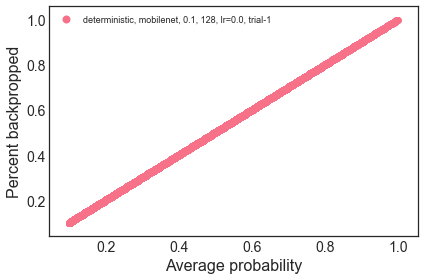

../data/output/cifar10/190116_dists/pickles/probabilities_by_image/lowk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_probabilities.pickle
../data/output/cifar10/190116_dists/pickles/image_id_hist/lowk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_images_hist.pickle
../plots/batch_stats/190116_dists/bps_by_prob_lowk.pdf


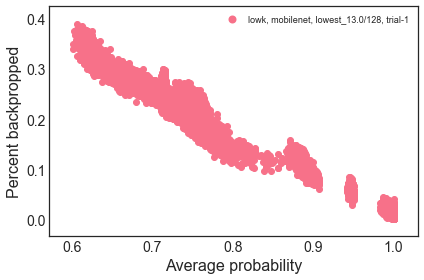

../data/output/cifar10/190116_dists/pickles/probabilities_by_image/randomk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_probabilities.pickle
../data/output/cifar10/190116_dists/pickles/image_id_hist/randomk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_images_hist.pickle
../plots/batch_stats/190116_dists/bps_by_prob_randomk.pdf


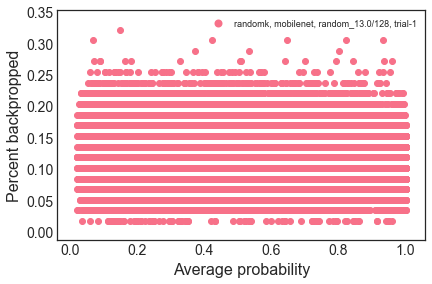

../data/output/cifar10/190116_dists/pickles/probabilities_by_image/topk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_probabilities.pickle
../data/output/cifar10/190116_dists/pickles/image_id_hist/topk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_images_hist.pickle


EOFError: 

<Figure size 432x288 with 0 Axes>

In [31]:

plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "190116_dists"
plot_dir = "{}/{}".format(plot_home_dir, experiment_batch_name)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_name = "190116_dists"
metadatas = ["deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337",
             "lowk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337",
             "randomk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337",
             "topk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337"]
for metadata in metadatas:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    probs_file = os.path.join(experiment_dir,
                              "pickles",
                              "probabilities_by_image",
                              "{}_probabilities.pickle".format(metadata))
    backprops_file = os.path.join(experiment_dir,
                              "pickles",
                              "image_id_hist",
                              "{}_images_hist.pickle".format(metadata))
    plot_percent_backpropped_by_prob([probs_file], [backprops_file], [metadata], plot_dir)
    
    
    

In [29]:

plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "190116_dists"
plot_dir = "{}/{}".format(plot_home_dir, experiment_batch_name)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["190116_shuffle0.001", "190116_shuffle0.01", "190116_shuffle0.1"]
fractions_shuffled = [0.001, 0.01, 0.1]
metadata = "deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337"
for experiment_name, fraction_shuffled, in zip(experiment_names, fractions_shuffled):
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    backprops_file = os.path.join(experiment_dir,
                              "pickles",
                              "image_id_hist",
                              "{}_images_hist.pickle".format(metadata))
    find_outliers([backprops_file], [metadata], fraction_shuffled)
    
    
    

Found 0.54 of shuffled by searching through 0.001 of data
Found 0.722 of shuffled by searching through 0.01 of data
Found 0.8346 of shuffled by searching through 0.1 of data
